## Loading the data

In [31]:
from collections import defaultdict
from cpa.helper import evaluate_r2_, evaluate_mmd, evaluate_emd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
adata = sc.read('../datasets/sciplex3_new.h5ad')
adata_old = sc.read('../datasets/sciplex3_old_reproduced.h5ad')
adata.obs = adata_old.obs

In [18]:
ood = adata.obs[adata.obs['split']=='ood'][['cell_type', 'condition']].drop_duplicates()
ood_dict = {}
ood_dict['K562'] = ood[ood['cell_type'] == 'K562']['condition'].unique()
ood_dict['A549'] = ood[ood['cell_type'] == 'A549']['condition'].unique()
ood_dict['MCF7'] = ood[ood['cell_type'] == 'MCF7']['condition'].unique()

adata = adata[(adata.obs['control'] == 1) | (adata.obs['dose'] == 1000)]

for ct in ['A549', 'K562', 'MCF7']:
    adata.obs[f'split_{ct}'] = adata.obs['split'].astype(str)
    adata.obs[f'split_{ct}'][
        (adata.obs['cell_type']==ct) & (adata.obs['condition'].isin(ood_dict[ct]))
    ] = 'ood'

Trying to set attribute `.obs` of view, copying.


In [19]:
preds = defaultdict(dict)
for model in ['cpa', 'cpa_sample', 'scgen']:
    for ct in ['A549', 'K562', 'MCF7']:
        preds[model][ct] = sc.read(f'preds_{model}_{ct}.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [20]:
de_genes_dict = {}
for ct in ['A549', 'K562', 'MCF7']:
    de_genes_dict[ct] = {
        key.split('_')[1]: value 
        for key, value 
        in adata.uns['rank_genes_groups_cov'].items() 
        if (ct in key) and ('0.1' in key)
    }

In [21]:
df_r2 = defaultdict(dict)
df_emd = defaultdict(dict)
df_mmd = defaultdict(dict)

for ct in ['A549', 'K562', 'MCF7']:
    print(ct)
    adata_ood = adata[adata.obs[f'split_{ct}'] == 'ood'].copy()
    df_r2['cpa'][ct] = evaluate_r2_(
        adata_ood, 
        preds['cpa'][ct], 
        condition_key='condition', 
        sampled=False, 
        de_genes_dict=de_genes_dict[ct]
    )
    df_r2['cpa_sample'][ct] = evaluate_r2_(
        adata_ood, 
        preds['cpa_sample'][ct], 
        condition_key='condition', 
        sampled=True, 
        de_genes_dict=de_genes_dict[ct]
    )
    df_r2['scgen'][ct] = evaluate_r2_(
        adata_ood, 
        preds['scgen'][ct], 
        condition_key='condition', 
        sampled=True, 
        de_genes_dict=de_genes_dict[ct]
    )
    
for ct in ['A549', 'K562', 'MCF7']:
    print(ct)
    adata_ood = adata[adata.obs[f'split_{ct}'] == 'ood'].copy()
    
    for model in ['cpa', 'cpa_sample', 'scgen']:
        df_emd[model][ct] = evaluate_emd(
            adata_ood, 
            preds[model][ct], 
            condition_key='condition', 
            de_genes_dict=de_genes_dict[ct]
        )

A549
K562
MCF7
A549
K562
MCF7


In [ ]:
for ct in ['A549', 'K562', 'MCF7']:
    print(ct)
    adata_ood = adata[adata.obs[f'split_{ct}'] == 'ood'].copy()
    
    for model in ['cpa', 'cpa_sample', 'scgen']:
        print(model)
        df_mmd[model][ct] = evaluate_mmd(
            adata_ood, 
            preds[model][ct], 
            condition_key='condition', 
            de_genes_dict=de_genes_dict[ct]
        )

A549
cpa
cpa_sample
scgen
K562
cpa
cpa_sample
scgen
MCF7
cpa
cpa_sample
scgen


In [ ]:
print(2)

In [ ]:
df_emd.keys()

In [22]:
emd_list = []
for k1 in df_emd.keys():
    for k2 in df_emd[k1].keys():
        df_tmp = df_emd[k1][k2]
        df_tmp = df_tmp.assign(model=k1)
        df_tmp = df_tmp.assign(ct=k2)
        emd_list.append(df_tmp)
df_emd_full = pd.concat(emd_list)

In [12]:
mmd_list = []
for k1 in df_mmd.keys():
    for k2 in df_mmd[k1].keys():
        df_tmp = df_mmd[k1][k2]
        df_tmp = df_tmp.assign(model=k1)
        df_tmp = df_tmp.assign(ct=k2)
        mmd_list.append(df_tmp)
df_mmd_full = pd.concat(mmd_list)

In [23]:
r2_list = []
for k1 in df_r2.keys():
    for k2 in df_r2[k1].keys():
        df_tmp = df_r2[k1][k2]
        df_tmp = df_tmp.assign(model=k1)
        df_tmp = df_tmp.assign(ct=k2)
        r2_list.append(df_tmp)
df_r2_full = pd.concat(r2_list)

In [25]:
df = pd.concat([df_r2_full, df_emd_full], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

In [26]:
df


,r2_mean,r2_var,r2_mean_deg,r2_var_deg,model,ct,emd,emd_deg
condition,,,,,,,,
Enzastaurin,0.983241,-0.073817,0.997686,-0.499689,cpa,A549,0.030637,0.145747
Luminespib,0.982585,-0.069466,0.991955,-0.473856,cpa,A549,0.030220,0.179701
Fulvestrant,0.970730,-0.069569,0.989096,-0.199195,cpa,A549,0.033765,0.110690
Mesna,0.981084,-0.069516,0.994812,-0.132000,cpa,A549,0.030761,0.069715
Cediranib,0.979185,-0.071417,0.983027,-0.343902,cpa,A549,0.030818,0.149484
...,...,...,...,...,...,...,...,...
Enzastaurin,0.979227,0.662767,0.977606,0.883771,scgen,MCF7,0.013174,0.051457
Fasudil,0.970699,0.610542,0.990123,0.763755,scgen,MCF7,0.015226,0.037834
Luminespib,0.949463,0.602847,0.943490,0.582075,scgen,MCF7,0.013418,0.169195


In [27]:
df.to_csv('scgen_results_full.csv')

In [36]:
df_full = pd.melt(df, id_vars=['model', 'ct'])
df_full = df_full[df_full['model'].isin(['cpa_sample', 'scgen'])]
df_full['model'][df_full['model'].str.contains('cpa')] = 'cpa'

Text(0.5, 0.98, 'OOD prediction performance')

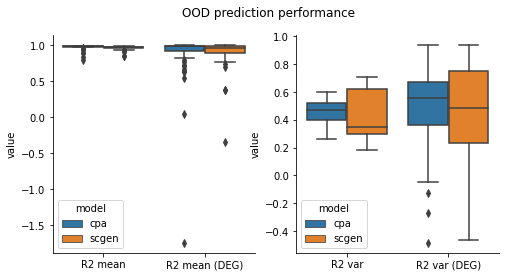

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
df_plot = df_full[df_full['variable'].str.contains('mean')]
sns.boxplot(x='variable', y='value', hue='model', data=df_plot, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_xticklabels(['R2 mean', 'R2 mean (DEG)'])
                    
df_plot = df_full[df_full['variable'].str.contains('var')]
sns.boxplot(x='variable', y='value', hue='model', data=df_plot, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_xticklabels(['R2 var', 'R2 var (DEG)'])
sns.despine()
plt.suptitle('OOD prediction performance')
#plt.savefig('../figures/scgen_comparison.png', dpi=600, bbox_inches='tight')

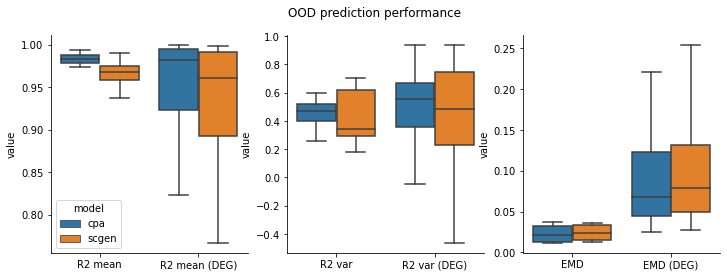

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_plot = df_full[df_full['variable'].str.contains('mean')]
sns.boxplot(x='variable', y='value', hue='model', data=df_plot, ax=ax[0], showfliers=False)
ax[0].set_xlabel('')
ax[0].set_xticklabels(['R2 mean', 'R2 mean (DEG)'])
                    
df_plot = df_full[df_full['variable'].str.contains('var')]
sns.boxplot(x='variable', y='value', hue='model', data=df_plot, ax=ax[1], showfliers=False)
ax[1].set_xlabel('')
ax[1].set_xticklabels(['R2 var', 'R2 var (DEG)'])
ax[1].get_legend().remove()

df_plot = df_full[df_full['variable'].str.contains('emd')]
sns.boxplot(x='variable', y='value', hue='model', data=df_plot, ax=ax[2], showfliers=False)
ax[2].set_xlabel('')
ax[2].set_xticklabels(['EMD', 'EMD (DEG)'])
ax[2].get_legend().remove()
sns.despine()
plt.suptitle('OOD prediction performance')
plt.savefig('../figures/scgen_comparison_emd.png', dpi=600, bbox_inches='tight')

In [39]:
df_full[df_full['variable'].str.contains('mean')].groupby(['variable','model']).median()

value
variable    model          
r2_mean     cpa    0.982852
            scgen  0.968109
r2_mean_deg cpa    0.982011
            scgen  0.960580

In [40]:
df_full[df_full['variable'].str.contains('var')].groupby(['variable','model']).median()

value
variable   model          
r2_var     cpa    0.468978
           scgen  0.345195
r2_var_deg cpa    0.556863
           scgen  0.484003

In [41]:
df_full[df_full['variable'].str.contains('emd')].groupby(['variable','model']).median()

value
variable model          
emd      cpa    0.020881
         scgen  0.023534
emd_deg  cpa    0.068446
         scgen  0.078964

In [43]:
((0.982852-0.968109) / 0.968109) * 100

1.5228657103693852

In [44]:
((0.468978-0.345195) / 0.345196) * 100

35.85875850241603

In [42]:
((0.020881-0.023534) / 0.0234534) * 100

-11.311792746467459